# Training notebook 

In this notebook, we will create the graph, build the STGNN model, perform training, and evaluation.

# Create Dataset object 

Dataset is a fundamental object created based on TabularDataset from the TSL library. Using this object, we will be able to enabling efficient loading, preprocessing, and spatiotemporal structuring of data.

In [2]:
from typing import Optional, Union, List
import numpy as np
import pandas as pd 

from tsl.datasets.prototypes import TabularDataset
from tsl.ops.similarities import gaussian_kernel

class Dataset(TabularDataset):

    similarity_options = {'distance', 'grid'}

    def __init__(self,
                 root: str = None
                 ):

        self.root = root

        # Load data
        # target, mask, u, dist, metadata = self.load()
        target, mask, u = self.load()

        covariates = {
            'u': (u),
            # 'metadata' : (metadata),
            # 'distances': (dist)
        }

        super().__init__(target=target,
                         mask=mask,
                         covariates=covariates,
                         similarity_score='distance',
                         temporal_aggregation='mean',
                         spatial_aggregation='mean',
                         name='SoilWaterDataset')

    def load(self):
        """
        Load data from files.

        Returns:
            tuple: Containing target, mask, covariates, distances, and metadata.
        """
        target_path = f"{self.root}target.npy"
        mask_path = f"{self.root}mask.npy"
        # dist_path = f"{self.root}distance_matrix.npy"
        covariates_path = f"{self.root}covariates.npy"
        metadata_path = f"{self.root}metadata.npy"

        target = np.load(target_path)
        mask = np.load(mask_path)
        u = np.load(covariates_path)
        # dist = np.load(dist_path)
        # metadata = np.load(metadata_path)

        return target, mask, u, # dist, metadata


    def compute_similarity(self, method: str, **kwargs):
        """
        Compute similarity matrix based on the specified method.

        Args:
            method (str): The similarity computation method ('distance' or 'grid').
            **kwargs: Additional keyword arguments for similarity computation.

        Returns:
            numpy.ndarray: Computed similarity matrix.

        Raises:
            ValueError: If an unknown similarity method is provided.
        """
        if method == "distance":
            # Calculate a Gaussian kernel similarity from the distance matrix, using a default or provided 'theta'
            theta = kwargs.get('theta', np.std(self.distances))
            return gaussian_kernel(self.distances, theta=theta)
        elif method == "grid":
            dist = self.distances.copy()
            dist[dist > 16] = np.inf  # keep only grid edges
            theta = kwargs.get('theta', 20)
            return gaussian_kernel(dist, theta=theta)
        else:
            raise ValueError(f"Unknown similarity method: {method}")

In [3]:
dataset = Dataset(root='soil-water-forecasting/modeling-pipeline/data/05_model_input/')

In [4]:
dataset.target

array([[[-1.1281431 ],
        [-1.1281431 ],
        [-1.1281431 ],
        ...,
        [-0.70538557],
        [-0.7169619 ],
        [-0.72203696]],

       [[-1.0917815 ],
        [-1.0917815 ],
        [-1.0917815 ],
        ...,
        [-1.437797  ],
        [-1.4478774 ],
        [-1.4668473 ]],

       [[ 1.6770688 ],
        [ 1.6770688 ],
        [ 1.6770688 ],
        ...,
        [-0.73884565],
        [-0.75437915],
        [-0.7771143 ]],

       ...,

       [[-0.6637499 ],
        [-0.6637499 ],
        [-0.6637499 ],
        ...,
        [-1.440809  ],
        [-1.4376827 ],
        [-1.4371167 ]],

       [[-0.23538063],
        [-0.23538063],
        [-0.23538063],
        ...,
        [ 3.4855433 ],
        [ 3.4627023 ],
        [ 3.4391837 ]],

       [[ 1.0787138 ],
        [ 1.0787138 ],
        [ 1.0787138 ],
        ...,
        [ 0.7280884 ],
        [ 0.7107348 ],
        [ 0.6917819 ]]], dtype=float32)

In [5]:
print(f"Has missing values: {dataset.has_mask}")

Has missing values: True


In [6]:
dataset.mask

array([[[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       ...,

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]],

       [[ True],
        [ True],
        [ True],
        ...,
        [ True],
        [ True],
        [ True]]])

In [7]:
dataset.set_mask(dataset.mask)

In [8]:
dataset.covariates

{'u': array([[[ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
           3.81469727e-02, -6.25960529e-02,  1.00000000e+00],
         [ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
           3.81469727e-02, -6.25960529e-02,  1.00000000e+00],
         [ 0.00000000e+00,  1.52587891e-04,  1.70898438e-03, ...,
           3.81469727e-02, -6.25960529e-02,  1.00000000e+00],
         ...,
         [ 2.71460205e+02,  8.39233398e-04,  1.35383606e-02, ...,
           3.39508057e-01,  1.08033419e-04,  1.00000000e+00],
         [ 2.71460205e+02,  8.39233398e-04,  1.34887695e-02, ...,
           3.37600708e-01,  1.08033419e-04,  1.00000000e+00],
         [ 2.71460205e+02,  8.23974609e-04,  1.34353638e-02, ...,
           3.37600708e-01,  1.08033419e-04,  1.00000000e+00]],
 
        [[ 0.00000000e+00,  7.62939453e-05,  4.45938110e-03, ...,
           8.20159912e-02, -1.95316970e-02,  1.00000000e+00],
         [ 0.00000000e+00,  7.62939453e-05,  4.45938110e-03, ...,
           8.201

# Create connectivity to our graph 

Here, we adjust the connectivity to retain only the five nearest neighbors (knn=5) per node, while excluding self-loops and normalizing along the specified axis.

In [9]:
# dataset.distances

In [10]:
# sim = dataset.compute_similarity("distance")  # or dataset.compute_similarity()

In [11]:
# sim

In [12]:
# # Adjust connectivity to reduce the number of edges
# connectivity = dataset.get_connectivity(  
#     method='distance',
#     knn=4,     
#     include_self=False,
#     force_symmetric=True, 
#     layout="csr",
# )

In [13]:
import torch

connectivity = torch.load("soil-water-forecasting/modeling-pipeline/data/05_model_input/connectivity.pt")

/tmp/ipykernel_1833/3741746759.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  connectivity = torch.load("soil-water-forecasting/modeling-pipeline/data/05_model_input/co

# Create torch_dataset 

torch_dataset, created using SpatioTemporalDataset from the tsl library, structures time-series and spatial data (target, covariates, mask, and connectivity) into a form optimized for spatiotemporal model training, enabling easy handling of lookback windows and prediction horizons in forecasting tasks.


In [14]:
from tsl.data import SpatioTemporalDataset

# covariates=dict(u=dataset.covariates['u'])
covariates=dataset.covariates
mask = dataset.mask

horizon=6
window=12
stride=1

torch_dataset = SpatioTemporalDataset(target=dataset.dataframe(),
                                      mask=mask,
                                      covariates=covariates,
                                      connectivity=connectivity,
                                      horizon=horizon, 
                                      window=window, 
                                      stride=stride 
                                      )

# Create datamodule

datamodule, created with SpatioTemporalDataModule, manages the SpatioTemporalDataset by applying scaling, splitting data into train/validation/test sets, and preparing data loaders with batch processing, enabling efficient, modular, and scalable data handling for deep learning models.

In [16]:
from tsl.data.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'target': MinMaxScaler(axis=(0, 1)),
    'u': MinMaxScaler(axis=(0, 1))
}

In [17]:
from tsl.data.datamodule import (SpatioTemporalDataModule,
                                 TemporalSplitter)
                                 
# Split data sequentially:
#   |------------ dataset -----------|
#   |--- train ---|- val -|-- test --|
splitter = TemporalSplitter(val_len=0.1, test_len=0.2)
# splitter = TemporalSplitter(val_len=0.1, test_len=0.023) # FOR PREDICTIONS

In [18]:
# Create a SpatioTemporalDataModule
datamodule = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    mask_scaling=True,
    splitter=splitter,
    batch_size=4, 
    workers=15
    )

print(datamodule)

SpatioTemporalDataModule(train_len=None, val_len=None, test_len=None, scalers=[target, u], batch_size=4)


In [19]:
datamodule.setup()

In [20]:
datamodule

SpatioTemporalDataModule(train_len=374, val_len=30, test_len=106, scalers=[target, u], batch_size=4)

# Create STGNN Model Architecture

The **TimeAndGraphAnisoModel** is built based on code from [HD-TTS
 repository](https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/time_and_graph_anisotropic.py) and the research paper by Cini et al. (2023d). This model utilizes spatiotemporal architectures equipped with anisotropic message passing for effective time and space representation.

### Reference
Cini, A., Marisca, I., Zambon, D., and Alippi, C. *Taming Local Effects in Graph-Based Spatiotemporal Forecasting.* In *Advances in Neural Information Processing Systems,* volume 36, pp. 55375–55393. Curran Associates, Inc., 2023.  
[https://arxiv.org/abs/2302.04071](https://arxiv.org/abs/2302.04071)


https://github.com/marshka/hdtts/blob/main/lib/nn/layers/anisotropic.py

In [21]:
from typing import Optional

import torch
from torch import nn, Tensor
from torch_geometric.nn import MessagePassing
from tsl.nn.blocks import RNNBase
from tsl.nn.layers import Dense, GraphGRUCellBase, Activation


class GraphAnisoConv(MessagePassing):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int = 1,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        super(GraphAnisoConv, self).__init__(aggr="add", node_dim=-2)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.msg_mlps = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2 * (in_channels if i == 0 else out_channels),
                          out_channels),
                Activation(activation),
                nn.Linear(out_channels, out_channels),
            )
            for i in range(kernel_size)
        ])

        edge_dim = edge_dim or 1  # accommodate for edge_weight
        self.lin_edge = nn.Linear(edge_dim, out_channels, bias=False)

        self.gate_mlp = Dense(out_channels, 1, activation='sigmoid')

        self.skip_conn = nn.Linear(in_channels, out_channels)
        self.activation = Activation(activation)

    def forward(self, x, edge_index, edge_attr: Optional[Tensor] = None):
        """"""
        out, x_ = 0, x
        for idx in range(self.kernel_size):
            x_ = self.propagate(edge_index, idx=idx, x=x_, edge_attr=edge_attr)
            out += x_
        out = self.activation(out + self.skip_conn(x))
        return out

    def message(self, x_i, x_j, idx, edge_attr: Optional[Tensor] = None):
        mij = self.msg_mlps[idx](torch.cat([x_i, x_j], -1))
        if edge_attr is not None:
            if edge_attr.ndim == 1:  # accommodate for edge_weight
                edge_attr = edge_attr.view(-1, 1)
            mij = mij + self.lin_edge(edge_attr)
        return self.gate_mlp(mij) * mij


class GraphAnisoGRUCell(GraphGRUCellBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        # instantiate gates
        forget_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        update_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                     edge_dim=edge_dim, activation=activation)
        candidate_gate = GraphAnisoConv(input_size + hidden_size, hidden_size,
                                        edge_dim=edge_dim,
                                        activation=activation)
        super(GraphAnisoGRUCell, self).__init__(hidden_size=hidden_size,
                                                forget_gate=forget_gate,
                                                update_gate=update_gate,
                                                candidate_gate=candidate_gate)


class GraphAnisoGRU(RNNBase):

    def __init__(self, input_size: int, hidden_size: int,
                 edge_dim: Optional[int] = None,
                 n_layers: int = 1, cat_states_layers: bool = False,
                 return_only_last_state: bool = False,
                 activation: str = 'leaky_relu'):
        self.input_size = input_size
        self.hidden_size = hidden_size
        rnn_cells = [
            GraphAnisoGRUCell(input_size if i == 0 else hidden_size,
                              hidden_size, edge_dim=edge_dim,
                              activation=activation)
            for i in range(n_layers)
        ]
        super(GraphAnisoGRU, self).__init__(rnn_cells, cat_states_layers,
                                            return_only_last_state)

https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/prototypes.py

In [22]:
from typing import Optional, Union, List

import torch
from torch import Tensor, nn
from torch_geometric.typing import Adj
from tsl.nn.blocks import MLPDecoder
from tsl.nn.layers import MultiLinear, NodeEmbedding
from tsl.nn.models import BaseModel
from tsl.nn.utils import maybe_cat_exog
from tsl.utils import ensure_list


def maybe_cat_emb(x: Tensor, emb: Optional[Tensor]):
    if emb is None:
        return x
    if emb.ndim < x.ndim:
        emb = emb[[None] * (x.ndim - emb.ndim)]
    emb = emb.expand(*x.shape[:-1], -1)
    return torch.cat([x, emb], dim=-1)


class STGNN(BaseModel):
    available_embedding_pos = {'encoding', 'decoding'}

    def __init__(self, input_size: int, horizon: int,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Optional[
                     Union[str, List[str]]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(STGNN, self).__init__()

        self.input_size = input_size
        self.horizon = horizon
        self.n_nodes = n_nodes
        self.output_size = output_size or input_size
        self.hidden_size = hidden_size
        self.exog_size = exog_size
        self.activation = activation

        # EMBEDDING
        if add_embedding_before is None:
            add_embedding_before = set()
        else:
            add_embedding_before = set(ensure_list(add_embedding_before))
            if not add_embedding_before.issubset(self.available_embedding_pos):
                raise ValueError("Parameter 'add_embedding_before' must be a "
                                 f"subset of {self.available_embedding_pos}")
        self.add_embedding_before = add_embedding_before

        if emb_size > 0:
            self.emb = NodeEmbedding(n_nodes, emb_size)
        else:
            self.register_module('emb', None)

        # ENCODER
        self.encoder_input = input_size + exog_size
        if 'encoding' in self.add_embedding_before and self.emb is not None:
            self.encoder_input += emb_size

        if use_local_weights is not None:
            self.use_local_weights = set(ensure_list(use_local_weights))
            if len(self.use_local_weights.difference(['encoder', 'decoder'])):
                raise ValueError("Parameter 'use_local_weights' must be "
                                 "'encoder', 'decoder', or both.")
        else:
            self.use_local_weights = set()

        if 'encoder' in self.use_local_weights:
            self.encoder = MultiLinear(self.encoder_input, hidden_size, n_nodes)
        else:
            self.encoder = nn.Linear(self.encoder_input, hidden_size)

        # DECODER
        self.decoder_input = hidden_size
        if 'decoding' in self.add_embedding_before and self.emb is not None:
            self.decoder_input += emb_size
        if 'decoder' in self.use_local_weights:
            raise NotImplementedError()
        else:
            self.decoder = MLPDecoder(input_size=self.decoder_input,
                                      hidden_size=self.hidden_size,
                                      output_size=self.output_size,
                                      horizon=self.horizon,
                                      activation=self.activation)

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        raise NotImplementedError

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: Optional[Tensor] = None,
                u: Optional[Tensor] = None,
                node_idx: Optional[Tensor] = None) -> Tensor:
        """"""
        # x: [batches steps nodes features]
        x = maybe_cat_exog(x, u)
        batch_size = x.size(0)
        emb = self.emb(expand=(batch_size, -1, -1),
                       node_index=node_idx) if self.emb is not None else None

        if 'encoding' in self.add_embedding_before and emb is not None:
            x = maybe_cat_emb(x, emb[:, None])

        # ENCODER   ###########################################################
        x = self.encoder(x)

        # SPATIOTEMPORAL MESSAGE-PASSING   ####################################
        out = self.stmp(x, edge_index, edge_weight, emb)

        # DECODER   ###########################################################
        if 'decoding' in self.add_embedding_before:
            out = maybe_cat_emb(out, emb)

        out = self.decoder(out)

        return out


class TimeAndSpace(STGNN):

    def __init__(self, input_size: int, horizon: int, stmp_conv: nn.Module,
                 n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 activation: str = 'elu'):
        super(TimeAndSpace, self).__init__(input_size=input_size,
                                           horizon=horizon,
                                           n_nodes=n_nodes,
                                           output_size=output_size,
                                           exog_size=exog_size,
                                           hidden_size=hidden_size,
                                           emb_size=emb_size,
                                           add_embedding_before=add_embedding_before,
                                           use_local_weights=use_local_weights,
                                           activation=activation)

        # STMP
        self.stmp_conv = stmp_conv

    def stmp(self, x: Tensor, edge_index: Adj,
             edge_weight: Optional[Tensor] = None,
             emb: Optional[Tensor] = None) -> Tensor:
        # spatiotemporal encoding
        out = self.stmp_conv(x, edge_index, edge_weight)
        return out


https://github.com/marshka/hdtts/blob/main/lib/nn/models/baselines/stgnns/time_and_graph_anisotropic.py

In [23]:
from typing import Union, List

class TimeAndGraphAnisoModel(TimeAndSpace):

    def __init__(self, input_size: int, horizon: int, n_nodes: int = None,
                 output_size: int = None,
                 exog_size: int = 0,
                 hidden_size: int = 32,
                 emb_size: int = 0,
                 add_embedding_before: Union[str, List[str]] = 'encoding',
                 use_local_weights: Union[str, List[str]] = None,
                 n_layers: int = 1,
                 activation: str = 'elu'):
        stmp_conv = GraphAnisoGRU(input_size=hidden_size,
                                  hidden_size=hidden_size,
                                  n_layers=n_layers,
                                  activation=activation,
                                  return_only_last_state=True)
        super(TimeAndGraphAnisoModel, self).__init__(
            input_size=input_size,
            horizon=horizon,
            stmp_conv=stmp_conv,
            n_nodes=n_nodes,
            output_size=output_size,
            exog_size=exog_size,
            hidden_size=hidden_size,
            emb_size=emb_size,
            add_embedding_before=add_embedding_before,
            use_local_weights=use_local_weights,
            activation=activation
        )


# Setup model 

Model is configured with hidden units, feed-forward layers, multiple SpatioTemporalConvNet blocks, and utilizes temporal and spatial convolution kernels, layer normalization, and gated mechanisms; it adapts to the dataset’s input size, number of nodes, horizon, and available exogenous features.

In [24]:
hidden_size = 32          # Number of hidden units
emb_size = 32
ff_size = 64             # Number of units in the feed-forward layers
n_layers = 3              # Number of SpatioTemporalConvNet blocks
temporal_kernel_size = 3  # Size of the temporal convolution kernel
spatial_kernel_size = 3   # Order of the spatial diffusion process
norm='layer'
gated=True

input_size = torch_dataset.n_channels
n_nodes = torch_dataset.n_nodes
horizon = torch_dataset.horizon
exog_size = torch_dataset.input_map.u.shape[-1] if 'u' in torch_dataset else 0

add_embedding_before = ['encoding', 'decoding']
activation = 'elu'

In [25]:
model = TimeAndGraphAnisoModel(
    input_size=input_size,
    horizon=horizon,
    n_nodes=n_nodes,
    output_size=input_size,
    exog_size=exog_size,
    hidden_size=hidden_size,
    emb_size=emb_size,
    add_embedding_before=add_embedding_before,
    activation=activation
)

# Print the model architecture
print(model)

TimeAndGraphAnisoModel(
  (emb): NodeEmbedding(n_nodes=64800, embedding_size=32)
  (encoder): Linear(in_features=50, out_features=32, bias=True)
  (decoder): MLPDecoder(
    (readout): MLP(
      (mlp): Sequential(
        (0): Dense(
          (affinity): Linear(in_features=64, out_features=32, bias=True)
          (activation): ELU(alpha=1.0)
          (dropout): Identity()
        )
      )
      (readout): Linear(in_features=32, out_features=6, bias=True)
    )
    (rearrange): Rearrange('b n (h f) -> b h n f', f=1, h=6)
  )
  (stmp_conv): GraphAnisoGRU(cell=GraphAnisoGRUCell, return_only_last_state=True)
)


In [26]:
def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

In [27]:
print_model_size(model)

Number of model (TimeAndGraphAnisoModel) parameters:   2099497


# Setup training 

This setup initializes a Predictor for the model with a masked mean-squared error loss function and multiple evaluation metrics (MSE, MAE, MAPE, and specific MSE at selected timesteps), then configures a Trainer using PyTorch Lightning with early stopping and model checkpointing based on validation MSE, gradient clipping to prevent exploding gradients, and 16-bit precision for efficient training.

In [28]:
from tsl.metrics.torch import MaskedMSE, MaskedMAE, MaskedMRE
from tsl.engines import Predictor

# Define the loss function
loss_fn = MaskedMAE()

# Setup metrics
metrics = {
    'mae': MaskedMAE(),
    'mse': MaskedMSE(),
    'mre': MaskedMRE(),
    'mae_at_1': MaskedMAE(at=0), 
    'mae_at_3': MaskedMAE(at=2), 
    'mae_at_6': MaskedMAE(at=5) 
}

In [29]:
# Setup predictor
predictor = Predictor(
    model=model,
    optim_class=torch.optim.Adam,
    optim_kwargs={'lr': 0.001},
    loss_fn=loss_fn,
    metrics=metrics
)


https://lightning.ai/docs/pytorch/stable/common/trainer.html

In [30]:
from pathlib import Path
from datetime import datetime
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

early_stop_callback = EarlyStopping(
    monitor='val_mse',
    patience=30,
    mode='min'
)

In [31]:
# Generate a timestamp for the logs directory
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Logs directory with timestamp
dirpath = Path(f'soil-water-forecasting/modeling-pipeline/data/06_models/TimeAndGraphAniso/logs/log_{timestamp}')

# Ensure the directory exists
dirpath.mkdir(parents=True, exist_ok=True)

# Model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=dirpath,
    save_top_k=1,
    monitor='val_mse',
    mode='min',
)

print(f"Checkpoints will be saved in: {dirpath}")

Checkpoints will be saved in: soil-water-forecasting/modeling-pipeline/data/06_models/TimeAndGraphAniso/logs/log_2025-01-03_11-50-07


In [32]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir=dirpath, name='TimeAndGraphAnisoModel')

In [33]:
# Setup trainer
trainer = pl.Trainer(max_epochs=100, 
                     logger=logger, 
                     limit_train_batches=100,
                     callbacks=[early_stop_callback, checkpoint_callback],
                     log_every_n_steps=2,
                     gradient_clip_val=5,    
                     precision=16
                     )

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs


# Training 

In [34]:
# Set float32 matmul precision to 'medium' or 'high'
torch.set_float32_matmul_precision('medium')

1L40S

In [39]:
train = False

155 minut trening 42 GB VRAMU 

In [40]:
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

if train == True:
    trainer.fit(predictor, datamodule=datamodule)
    # Path to the best checkpoint
    best_checkpoint_path = checkpoint_callback.best_model_path
    predictor.load_model(best_checkpoint_path)
else:
    predictor.load_model('/teamspace/studios/this_studio/soil-water-forecasting/modeling-pipeline/data/06_models/TimeAndGraphAniso/logs/log_2025-01-03_11-50-07/epoch=32-step=3069.ckpt')


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/tsl/engines/predictor.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  storage = torch.load(filename,

# Evaluation

In [41]:
predictor.freeze()

In [42]:
trainer.test(predictor, dataloaders=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │            nan            │
│         test_mae          │            nan            │
│       test_mae_at_1       │            nan            │
│       test_mae_at_3       │            nan            │
│       test_mae_at_6       │            nan            │
│         test_mre          │            nan            │
│         test_mse          │            nan            │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': nan,
  'test_mae_at_1': nan,
  'test_mae_at_3': nan,
  'test_mae_at_6': nan,
  'test_mre': nan,
  'test_mse': nan,
  'test_loss': nan}]

# Predict

In [ ]:
# Assuming you have a datamodule set up
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

# Count the number of batches
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)
num_test_batches = len(test_dataloader)

print(f"Number of training batches: {num_train_batches}")
print(f"Number of validation batches: {num_val_batches}")
print(f"Number of test batches: {num_test_batches}")


Number of training batches: 93
Number of validation batches: 8
Number of test batches: 27


In [ ]:
splitter.indices

{'train': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175,

## val data

In [ ]:
datamodule.test_dataloader()

In [ ]:
predictions = trainer.predict(predictor, dataloaders=datamodule.test_dataloader())

INFO:tsl:Set scaler for target: MinMaxScaler(bias=(1, 1, 1), scale=(1, 1, 1))
INFO:tsl:Set scaler for u: MinMaxScaler(bias=(1, 1, 20), scale=(1, 1, 20))
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# predictions

In [ ]:
np.save('soil-water-forecasting/modeling-pipeline/data/07_model_output/predictions.npy', predictions)

In [ ]:
# import torch
# import numpy as np
# import xarray as xr
# import pandas as pd
# import logging

# # Configure logging for debugging
# logging.basicConfig(level=logging.INFO)
# logger = logging.getLogger(__name__)

# # Define paths
# predictions_path = 'soil-water-forecasting/modeling-pipeline/data/07_model_output/predictions.npy'
# original_dataset_path = 'soil-water-forecasting/modeling-pipeline/data/04_feature/features.nc'

# # Load the predictions
# predictions = np.load(predictions_path, allow_pickle=True)
# logger.info(f"Loaded predictions with shape: {len(predictions)}")

# # Load the original dataset
# ds = xr.open_dataset(original_dataset_path)
# logger.info("Loaded original dataset.")

# # Convert 'valid_time' to datetime objects
# dates = pd.to_datetime(ds['valid_time'].values)
# logger.info(f"Loaded dates from 'valid_time', total dates: {len(dates)}")

# # Initialize lists to store all y and y_hat predictions
# y_all_list = []
# y_hat_all_list = []

# for idx, pred in enumerate(predictions):
#     # Extract 'y' and 'y_hat' and remove the last dimension (features)
#     y_batch = pred['y'].squeeze(-1)         # Shape: (batch, horizon, nodes)
#     y_hat_batch = pred['y_hat'].squeeze(-1) # Shape: (batch, horizon, nodes)

#     # Append all steps in the horizon
#     y_all_list.append(y_batch)
#     y_hat_all_list.append(y_hat_batch)
#     logger.debug(f"Processed prediction {idx+1}/{len(predictions)}")

# # Concatenate all batches to form the complete arrays
# y_all = torch.cat(y_all_list, dim=0).numpy()         # Shape: (N, 6, 64800)
# y_hat_all = torch.cat(y_hat_all_list, dim=0).numpy() # Shape: (N, 6, 64800)
# logger.info(f"Concatenated y_all shape: {y_all.shape}")
# logger.info(f"Concatenated y_hat_all shape: {y_hat_all.shape}")

# # Define desired number of forecasts based on test set
# desired_forecasts = 12  # Number of test indices

# # # Access the splitter dictionary
# # splitter = {
# #     'train': np.arange(0, 457),
# #     'val': np.arange(469, 509),
# #     'test': np.array([521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532])
# # }

# splitter = splitter.indices
# logger.info("Defined splitter with train, val, and test splits.")

# # Verify splitter structure
# logger.info(f"Splitter keys: {splitter.keys()}")
# logger.info(f"Number of test indices: {len(splitter['test'])}")

# # Ensure that 'test_indices' has at least 'desired_forecasts' entries
# if len(splitter['test']) < desired_forecasts:
#     raise ValueError(f"Not enough test indices. Expected at least {desired_forecasts}, but got {len(splitter['test'])}")

# # Retrieve test indices corresponding to desired forecasts
# test_indices = splitter['test'][:desired_forecasts]
# logger.info(f"Selected test indices: {test_indices}")

# # Assign forecast_time based on test_indices
# forecast_time = dates[test_indices]
# logger.info(f"Assigned forecast_time from test indices: {forecast_time}")

# # **Important Correction: Ensure that y_all corresponds to test forecasts**

# # **Scenario 1: predictions.npy contains only test set predictions**
# # Check if y_all length matches test_indices
# if y_all.shape[0] != desired_forecasts:
#     logger.warning(f"Number of predictions ({y_all.shape[0]}) does not match desired_forecasts ({desired_forecasts}). Adjusting accordingly.")
#     # Depending on how predictions are structured, adjust here.
#     # For simplicity, we'll take the first 'desired_forecasts' predictions.
#     y_all = y_all[:desired_forecasts, :, :]         # Shape: (12, 6, 64800)
#     y_hat_all = y_hat_all[:desired_forecasts, :, :] # Shape: (12, 6, 64800)
#     logger.info(f"Sliced y_all shape to: {y_all.shape}")
#     logger.info(f"Sliced y_hat_all shape to: {y_hat_all.shape}")

# # **Scenario 2: predictions.npy contains all set predictions (train, val, test)**
# # If y_all includes train and val forecasts, select only test forecasts based on test_indices.
# # This requires knowing the mapping between y_all and the original indices.
# # For simplicity, assuming predictions.npy contains only test set forecasts.

# # Define spatial dimensions
# n_lat = 180
# n_lon = 360
# horizon = 6  # Forecast horizon

# # Ensure that the total number of nodes matches
# expected_nodes = n_lat * n_lon
# if y_all.shape[2] != expected_nodes:
#     raise ValueError(f"Expected {expected_nodes} nodes, but got {y_all.shape[2]} in predictions.")

# # Reshape y and y_hat to (forecast_time, horizon, latitude, longitude)
# y_all_reshaped = y_all.reshape(desired_forecasts, horizon, n_lat, n_lon)          # Shape: (12, 6, 180, 360)
# y_hat_all_reshaped = y_hat_all.reshape(desired_forecasts, horizon, n_lat, n_lon)  # Shape: (12, 6, 180, 360)

# # Define forecast steps (e.g., step 1 to step 6)
# forecast_steps = np.arange(1, horizon + 1)

# # Create the xarray.Dataset with corrected forecast_time
# ds_pred = xr.Dataset(
#     {
#         'y': (('forecast_time', 'horizon', 'latitude', 'longitude'), y_all_reshaped),
#         'y_hat': (('forecast_time', 'horizon', 'latitude', 'longitude'), y_hat_all_reshaped)
#     },
#     coords={
#         'forecast_time': forecast_time,          # Correctly aligned forecast times
#         'horizon': forecast_steps,               # 6 forecast steps
#         'latitude': ds['latitude'].values,
#         'longitude': ds['longitude'].values
#     }
# )

# # Display the Dataset
# print(ds_pred)

# # Optional: Save the Dataset
# # ds_pred.to_netcdf('soil-water-forecasting/modeling-pipeline/data/07_predictions/predictions_full_horizon.nc')


In [ ]:
import torch
import numpy as np
import xarray as xr
import pandas as pd

# Paths
predictions_path = 'soil-water-forecasting/modeling-pipeline/data/07_model_output/predictions.npy'
original_dataset_path = 'soil-water-forecasting/modeling-pipeline/data/04_feature/features.nc'

# Load predictions
predictions = np.load(predictions_path, allow_pickle=True)
print(f"Loaded predictions with shape: {predictions.shape}")  # e.g., (48,)

# Load original dataset
ds = xr.open_dataset(original_dataset_path)
print("Loaded original dataset.")

# Convert 'valid_time' to datetime objects
dates = pd.to_datetime(ds['valid_time'].values)
print(f"Loaded dates from 'valid_time', total dates: {len(dates)}")  # e.g., 550

# Extract test indices from the splitter
test_indices = splitter.indices['test']
print(f"Test indices: {test_indices}")

# Define desired number of forecast times and calculate required batches
desired_forecast_times = 106
batch_size = datamodule.batch_size  # Should be 4
required_batches = desired_forecast_times // batch_size
if desired_forecast_times % batch_size != 0:
    required_batches += 1  # To cover remaining forecast times

print(f"Desired forecast times: {desired_forecast_times}")
print(f"Batch size: {batch_size}")
print(f"Required number of batches: {required_batches}")

# Check if there are enough test indices
if len(test_indices) < desired_forecast_times:
    raise ValueError(f"Expected at least {desired_forecast_times} test forecasts, but got {len(test_indices)}")

# Select the required number of test indices
selected_test_indices = test_indices[:required_batches * batch_size]
print(f"Selected test indices: {selected_test_indices}")

# Assign forecast_time using the selected test indices
forecast_times = dates[selected_test_indices]
print(f"Assigned forecast_time from test indices: {forecast_times}")

# Initialize lists to store all y and y_hat predictions
y_all_list = []
y_hat_all_list = []

for idx, pred in enumerate(predictions[:required_batches]):
    # Extract 'y' and 'y_hat' and remove the last dimension (features)
    y_batch = pred['y'].squeeze(-1)          # Shape: (batch_size, horizon, nodes)
    y_hat_batch = pred['y_hat'].squeeze(-1)  # Shape: (batch_size, horizon, nodes)
    
    # Append all steps in the horizon
    y_all_list.append(y_batch)               # List of (batch_size, horizon, nodes)
    y_hat_all_list.append(y_hat_batch)       # List of (batch_size, horizon, nodes)
    
    print(f"Processed batch {idx+1}/{required_batches}")

# Concatenate all batches to form the complete arrays
y_all = torch.cat(y_all_list, dim=0).numpy()         # Shape: (12, 6, 64800)
y_hat_all = torch.cat(y_hat_all_list, dim=0).numpy() # Shape: (12, 6, 64800)

# Check shapes
print(f"y_all shape: {y_all.shape}")         # Expected: (12, 6, 64800)
print(f"y_hat_all shape: {y_hat_all.shape}") # Expected: (12, 6, 64800)

# Define spatial dimensions
n_lat = 180
n_lon = 360
horizon = 6  # Forecast horizon

# Ensure that the total number of nodes matches
assert y_all.shape[2] == n_lat * n_lon, f"Expected {n_lat * n_lon} nodes, got {y_all.shape[2]}"

# Reshape y and y_hat to (forecast_time, horizon, latitude, longitude)
y_all_reshaped = y_all.reshape(desired_forecast_times, horizon, n_lat, n_lon)          # Shape: (12, 6, 180, 360)
y_hat_all_reshaped = y_hat_all.reshape(desired_forecast_times, horizon, n_lat, n_lon)  # Shape: (12, 6, 180, 360)

# Define forecast steps (e.g., step 1 to step 6)
forecast_steps = np.arange(1, horizon + 1)

# Create the xarray.Dataset with corrected forecast_time
ds_pred = xr.Dataset(
    {
        'y': (('forecast_time', 'horizon', 'latitude', 'longitude'), y_all_reshaped),
        'y_hat': (('forecast_time', 'horizon', 'latitude', 'longitude'), y_hat_all_reshaped)
    },
    coords={
        'forecast_time': forecast_times,          # Corrected forecast starting points
        'horizon': forecast_steps,                # 6 forecast steps
        'latitude': ds['latitude'].values,
        'longitude': ds['longitude'].values
    }
)

# Display the corrected Dataset
print(ds_pred)


Loaded predictions with shape: (27,)
Loaded original dataset.
Loaded dates from 'valid_time', total dates: 550
Test indices: [427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516
 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532]
Desired forecast times: 106
Batch size: 4
Required number of batches: 27
Selected test indices: [427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444
 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462
 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480
 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498
 499 500 501 502 503 504 505 506 507 508 509 510 511 512

In [ ]:
ds_pred.to_netcdf('soil-water-forecasting/modeling-pipeline/data/07_model_output/predictions.nc')

In [ ]:
import xarray as xr

# Load the predictions
ds_pred = xr.open_dataset('soil-water-forecasting/modeling-pipeline/data/07_model_output/predictions.nc')

In [ ]:
ds_pred

<xarray.Dataset> Size: 330MB
Dimensions:        (forecast_time: 106, horizon: 6, latitude: 180,
                    longitude: 360)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 848B 2014-08-01 ... 2023-05-01
  * horizon        (horizon) int64 48B 1 2 3 4 5 6
  * latitude       (latitude) int64 1kB -90 -89 -88 -87 -86 ... 85 86 87 88 89
  * longitude      (longitude) int64 3kB 0 1 2 3 4 5 ... 354 355 356 357 358 359
Data variables:
    y              (forecast_time, horizon, latitude, longitude) float32 165MB ...
    y_hat          (forecast_time, horizon, latitude, longitude) float32 165MB ...

In [ ]:
import torch
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_full_horizon(ds, forecast_time_idx=0, vmin=None, vmax=None):
    """
    Visualize y_hat and y_true for all horizon steps for a specific forecast_time using a custom color scale.
    The maps are centered at 0° longitude.

    Parameters:
    - ds: xarray.Dataset containing 'y' and 'y_hat' variables with dimensions (forecast_time, horizon, latitude, longitude)
    - forecast_time_idx: Index of the forecast_time coordinate to visualize
    - vmin: Minimum value for color scaling (optional)
    - vmax: Maximum value for color scaling (optional)
    """
    
    # Define custom boundaries and colors
    custom_boundaries = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    custom_colors = ['red', 'orange', 'green', 'green', 'lightblue', 'blue']  # Reflect critical to excessive moisture
    
    # Create a ListedColormap and BoundaryNorm
    cmap = ListedColormap(custom_colors)
    norm = BoundaryNorm(custom_boundaries, cmap.N)
    
    # Extract data for the given forecast_time
    y_hat_all_steps = ds.y_hat.isel(forecast_time=forecast_time_idx).values  # Shape: (horizon, latitude, longitude)
    y_true_all_steps = ds.y.isel(forecast_time=forecast_time_idx).values      # Shape: (horizon, latitude, longitude)
    
    # Coordinates
    lats = ds.latitude.values
    lons = ds.longitude.values
    forecast_time_val = pd.to_datetime(ds.forecast_time.values[forecast_time_idx])  # Ensure it's a Timestamp
    
    # Calculate the start date (11 months before forecast_time_val)
    start_date = forecast_time_val - pd.DateOffset(months=11)
    
    # Format the dates
    start_str = start_date.strftime('%Y-%m')
    end_str = forecast_time_val.strftime('%Y-%m')
    
    # Define the actual forecast dates based on horizon
    horizon_steps = ds.horizon.values
    forecast_dates = [forecast_time_val + pd.DateOffset(months=int(step)) for step in horizon_steps]
    
    # Shift longitude from [0, 360] to [-180, 180] if necessary
    lons_shifted = np.where(lons > 180, lons - 360, lons)
    
    # Sort the longitudes and corresponding data
    sorted_indices = np.argsort(lons_shifted)
    lons_sorted = lons_shifted[sorted_indices]
    
    # Compute vmin/vmax if not provided
    if vmin is None:
        vmin = min(np.nanmin(y_hat_all_steps), np.nanmin(y_true_all_steps))
    if vmax is None:
        vmax = max(np.nanmax(y_hat_all_steps), np.nanmax(y_true_all_steps))
    
    # Set up the plot with two columns for y_hat and y_true
    fig, axes = plt.subplots(nrows=len(horizon_steps), ncols=2, figsize=(14, 4 * len(horizon_steps)), constrained_layout=True)
    fig.suptitle(
        f"Forecasting based on {start_str} to {end_str}",
        fontsize=16, fontweight='bold'
    )
    
    for step in range(len(horizon_steps)):
        # Extract data for the current horizon step
        y_hat_map = y_hat_all_steps[step]
        y_true_map = y_true_all_steps[step]
        forecast_date = forecast_dates[step].strftime('%Y-%m')
        
        # Plot y_hat
        ax_hat = axes[step, 0] if len(horizon_steps) > 1 else axes[0]
        mesh_hat = ax_hat.pcolormesh(lons_sorted, lats, y_hat_map[:, sorted_indices], cmap=cmap, norm=norm, shading='auto')
        ax_hat.set_title(f"y_hat - {forecast_date}", fontsize=14)
        ax_hat.set_xlabel("Longitude", fontsize=12)
        ax_hat.set_ylabel("Latitude", fontsize=12)
        ax_hat.set_xlim([-180, 180])
        ax_hat.set_ylim([-90, 90])
        ax_hat.grid(True, linestyle='--', alpha=0.5)
        
        # Add colorbar for y_hat
        if step == 0:
            cbar_hat = plt.colorbar(mesh_hat, ax=ax_hat, orientation='horizontal', fraction=0.046, pad=0.04, boundaries=custom_boundaries)
            cbar_hat.set_label("y_hat value", fontsize=12)
            cbar_hat.set_ticks(custom_boundaries)
            cbar_hat.set_ticklabels([f"{b:.1f}" for b in custom_boundaries])
        
        # Plot y_true
        ax_true = axes[step, 1] if len(horizon_steps) > 1 else axes[1]
        mesh_true = ax_true.pcolormesh(lons_sorted, lats, y_true_map[:, sorted_indices], cmap=cmap, norm=norm, shading='auto')
        ax_true.set_title(f"y_true - {forecast_date}", fontsize=14)
        ax_true.set_xlabel("Longitude", fontsize=12)
        ax_true.set_ylabel("Latitude", fontsize=12)
        ax_true.set_xlim([-180, 180])
        ax_true.set_ylim([-90, 90])
        ax_true.grid(True, linestyle='--', alpha=0.5)
        
        # Add colorbar for y_true
        if step == 0:
            cbar_true = plt.colorbar(mesh_true, ax=ax_true, orientation='horizontal', fraction=0.046, pad=0.04, boundaries=custom_boundaries)
            cbar_true.set_label("y_true value", fontsize=12)
            cbar_true.set_ticks(custom_boundaries)
            cbar_true.set_ticklabels([f"{b:.1f}" for b in custom_boundaries])
    
    plt.show()

# Example usage:
# Assuming 'ds_pred' is your xarray.Dataset and you want to visualize the 106th forecast time
# plot_full_horizon(ds_pred, forecast_time_idx=105)


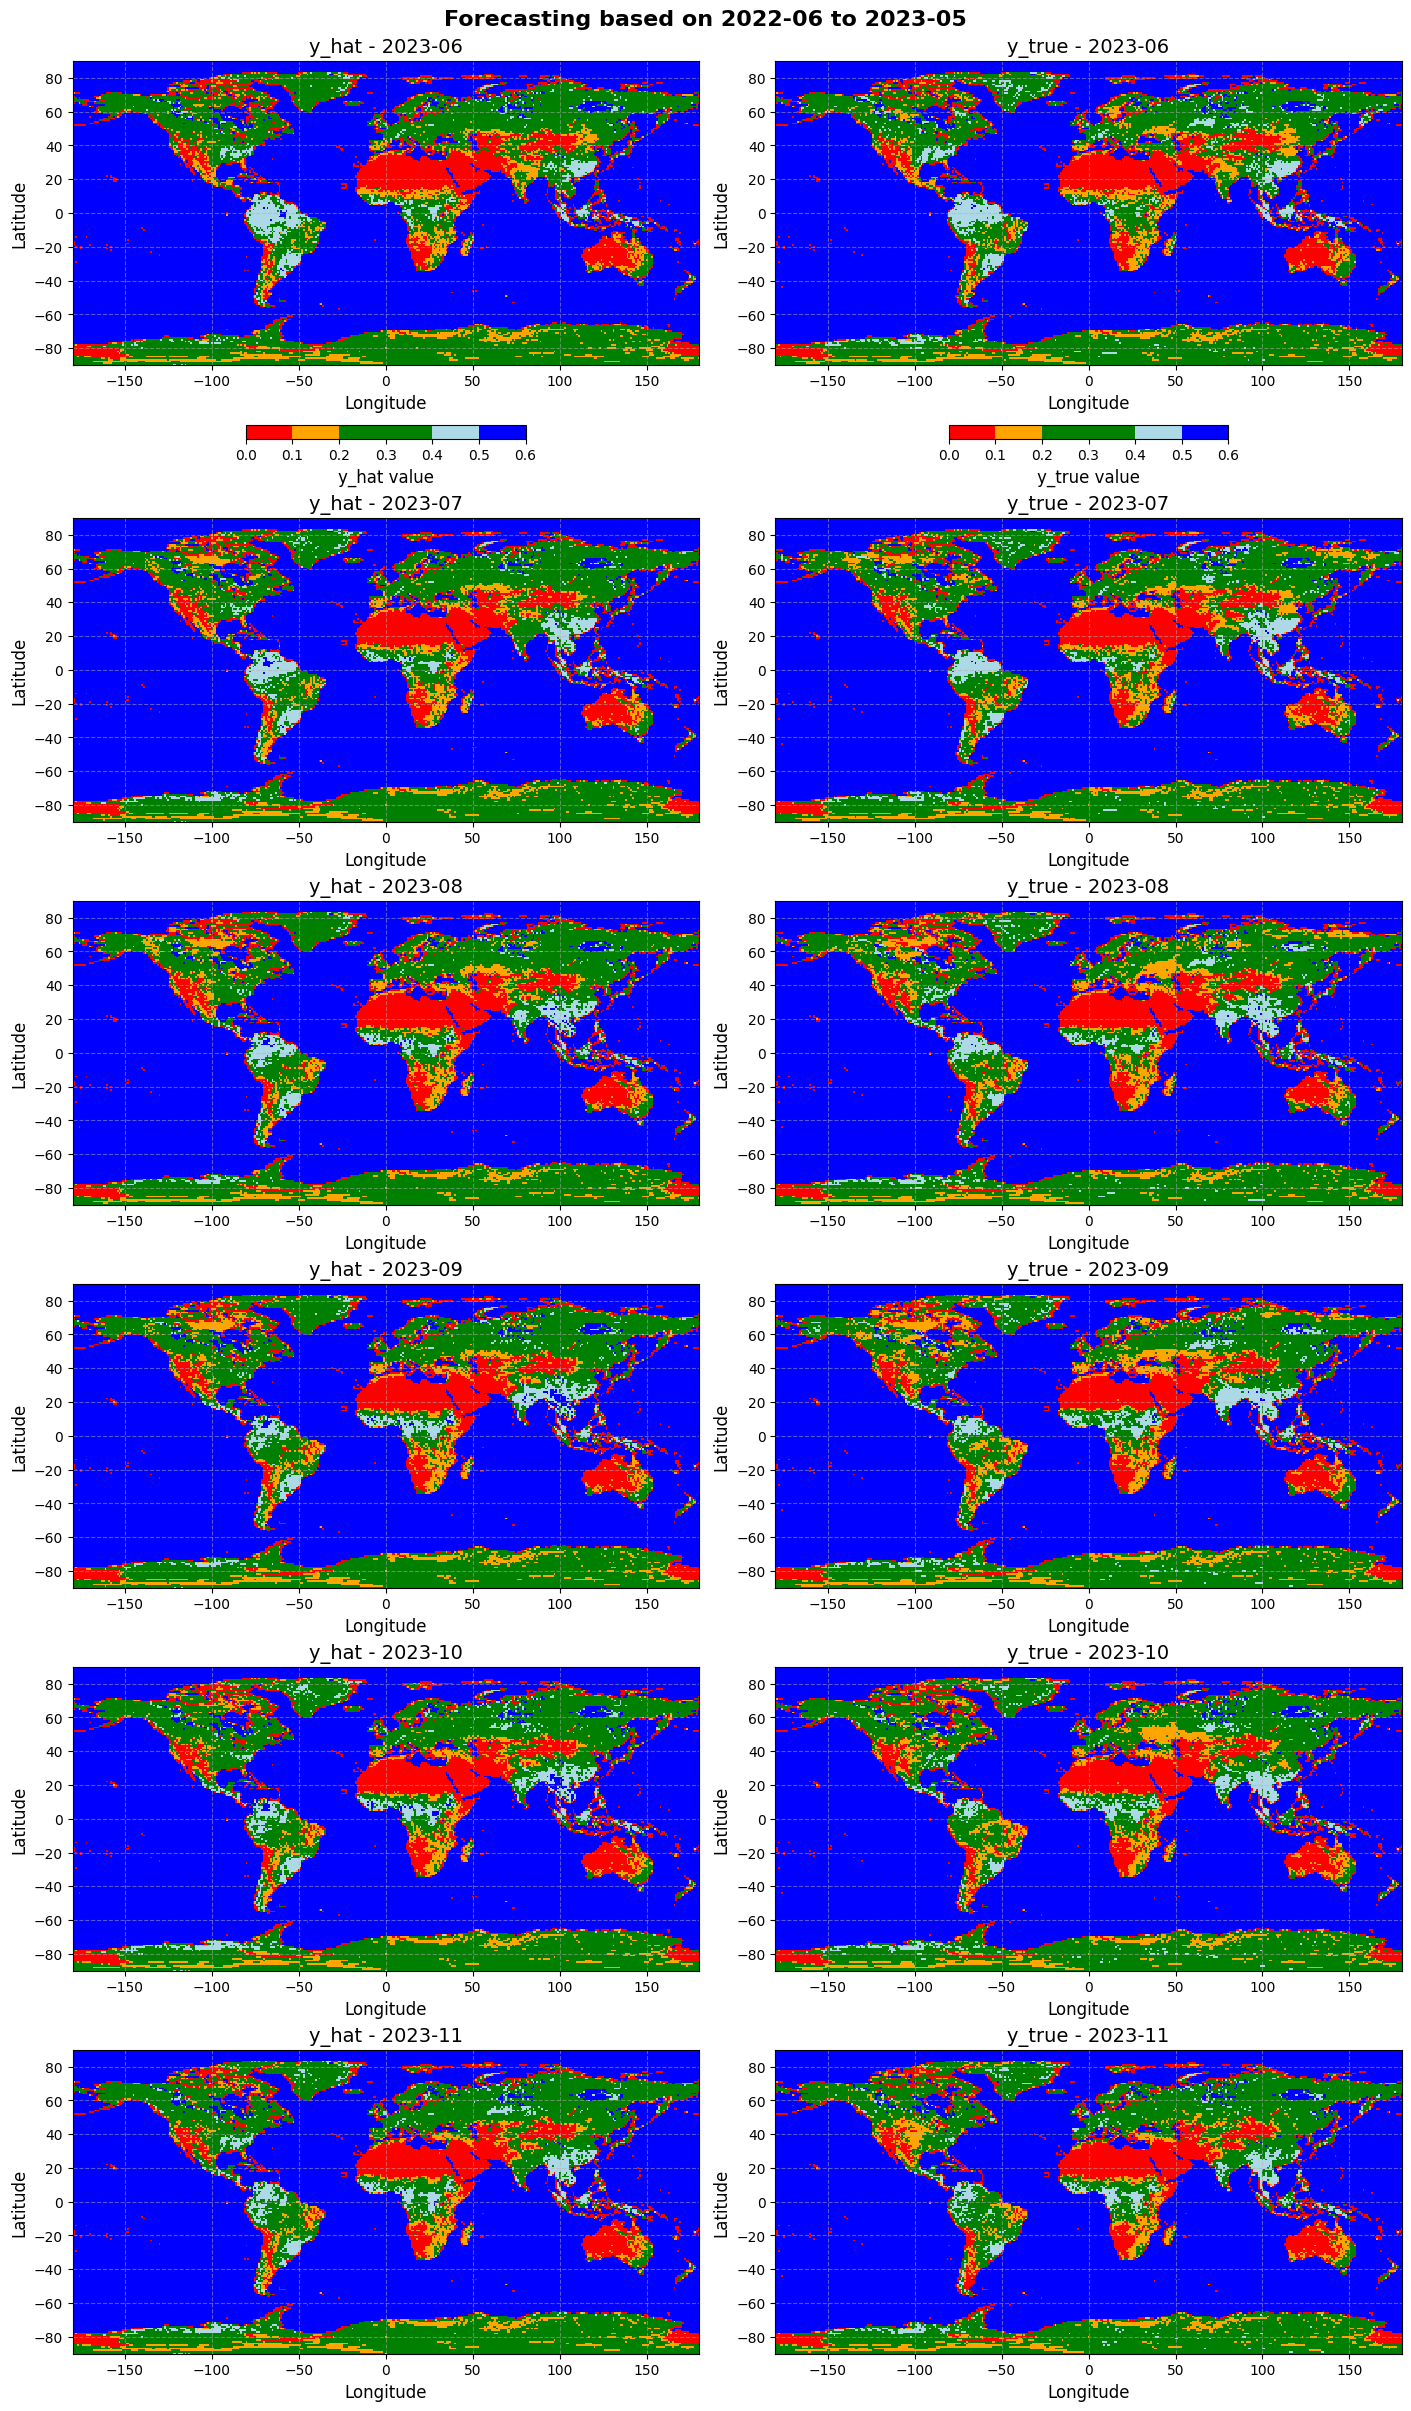

In [108]:
# Wizualizacja pełnych 6-miesięcznych prognoz dla pierwszej prognozy (forecast_time_idx=0)
plot_full_horizon(ds_pred, forecast_time_idx=105)


In [109]:
def plot_full_horizon_plotly(ds, forecast_time_idx=0):
    """
    Visualize y_hat and y_true for all horizon steps for a specific forecast_time using a custom color scale with Plotly.
    The maps are centered at 0° longitude.

    Parameters:
    - ds: xarray.Dataset containing 'y' and 'y_hat' variables with dimensions (forecast_time, horizon, latitude, longitude)
    - forecast_time_idx: Index of the forecast_time coordinate to visualize
    """
    # Define custom colorscale
    custom_colorscale = [
        [0.0, 'red'],        # 0.0 - red
        [0.1 / 0.6, 'orange'],  # 0.1
        [0.2 / 0.6, 'green'],   # 0.2
        [0.3 / 0.6, 'green'],   # 0.3
        [0.4 / 0.6, 'lightblue'],  # 0.4
        [1.0, 'blue']        # 0.6 and above - blue
    ]

    # Extract data for the given forecast_time
    y_hat_all_steps = ds.y_hat.isel(forecast_time=forecast_time_idx).values
    y_true_all_steps = ds.y.isel(forecast_time=forecast_time_idx).values

    # Coordinates
    lats = ds.latitude.values
    lons = ds.longitude.values
    forecast_time_val = pd.to_datetime(ds.forecast_time.values[forecast_time_idx])

    # Compute shared vmin and vmax
    vmin = 0.0
    vmax = 0.6

    # Shift longitude from [0, 360] to [-180, 180] if necessary
    lons_shifted = np.where(lons > 180, lons - 360, lons)
    sorted_indices = np.argsort(lons_shifted)
    lons_sorted = lons_shifted[sorted_indices]

    # Create a subplot with two columns and rows equal to the number of horizons
    horizon_steps = ds.horizon.values
    forecast_dates = [forecast_time_val + pd.DateOffset(months=int(step)) for step in horizon_steps]

    fig = make_subplots(
        rows=len(horizon_steps),
        cols=2,
        subplot_titles=[
            f"y_hat - {forecast_dates[i].strftime('%Y-%m')}" for i in range(len(horizon_steps))
        ] + [
            f"y_true - {forecast_dates[i].strftime('%Y-%m')}" for i in range(len(horizon_steps))
        ],
        horizontal_spacing=0.1,
        vertical_spacing=0.1,
    )

    for step in range(len(horizon_steps)):
        y_hat_map = y_hat_all_steps[step][:, sorted_indices]
        y_true_map = y_true_all_steps[step][:, sorted_indices]

        fig.add_trace(
            go.Heatmap(
                z=y_hat_map,
                x=lons_sorted,
                y=lats,
                colorscale=custom_colorscale,
                zmin=vmin,
                zmax=vmax,
                colorbar=dict(title="y_hat / y_true Value", len=0.4),
            ),
            row=step + 1,
            col=1,
        )

        fig.add_trace(
            go.Heatmap(
                z=y_true_map,
                x=lons_sorted,
                y=lats,
                colorscale=custom_colorscale,
                zmin=vmin,
                zmax=vmax,
                colorbar=dict(title="y_hat / y_true Value", len=0.4),
            ),
            row=step + 1,
            col=2,
        )

    fig.update_layout(
        title=f"Forecasting from {forecast_time_val.strftime('%Y-%m')} ({len(horizon_steps)} Horizons)",
        height=1200 * len(horizon_steps),
        width=2400,
        template="plotly_white",
    )

    fig.show()


In [111]:
# plot_full_horizon_plotly(ds_pred, forecast_time_idx=105)